## An implementation of the competition metric

This kernel is a clean-up of **Max Jeblick**'s evaluation metric implementation into an easy to use function: https://www.kaggle.com/maxjeblick/alaska2-efficientnet-on-tpus-competition-metric

See the [evaluation page](https://www.kaggle.com/c/alaska2-image-steganalysis/overview/evaluation) for more info about the metric!

**EDIT:** Changed to reflect the update in evaluation metric of the competition!

In [1]:
from sklearn import metrics
import numpy as np

def alaska_weighted_auc(y_true, y_valid):
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights =        [       2,   1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_valid, pos_label=1)
    
    # size of subsets
    areas = np.array(tpr_thresholds[1:]) - np.array(tpr_thresholds[:-1])
    
    # The total area is normalized by the sum of weights such that the final weighted AUC is between 0 and 1.
    normalization = np.dot(areas, weights)
    
    competition_metric = 0
    for idx, weight in enumerate(weights):
        y_min = tpr_thresholds[idx]
        y_max = tpr_thresholds[idx + 1]
        mask = (y_min < tpr) & (tpr < y_max)

        x_padding = np.linspace(fpr[mask][-1], 1, 100)

        x = np.concatenate([fpr[mask], x_padding])
        y = np.concatenate([tpr[mask], [y_max] * len(x_padding)])
        y = y - y_min # normalize such that curve starts at y=0
        score = metrics.auc(x, y)
        submetric = score * weight
        best_subscore = (y_max - y_min) * weight
        competition_metric += submetric
        
    return competition_metric / normalization

## A toy example

And a comparison to other evaluation metrics.  
We can see here that Weighted AUC gives  more favourable scores than both accuracy and standard AUC (before the metric update, this was even more pronounced! 0.64 AUC become 0.96 weighted AUC)

In [2]:
np.random.seed(42)

signal = np.random.random(1000)
labels = (signal > 0.5).astype(int)
preds = np.random.random(1000) + (signal - 0.5) * 0.3

In [3]:
auc = metrics.roc_auc_score(labels, preds)
weighted_auc = alaska_weighted_auc(labels, preds)
accuracy = (labels == (preds > 0.5)).mean()

print(f'   Accuracy = {round(accuracy, 5)}')
print(f'        AUC = {round(auc, 5)}')
print(f'WeightedAUC = {round(weighted_auc, 5)}')

   Accuracy = 0.564
        AUC = 0.64346
WeightedAUC = 0.72438


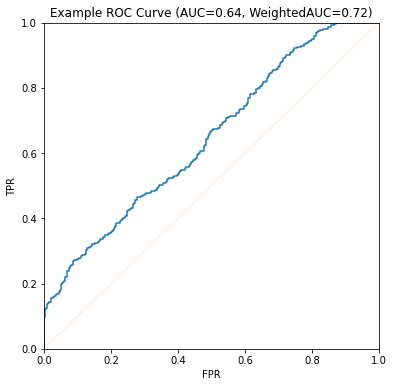

In [4]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(labels, preds, pos_label=1)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Example ROC Curve (AUC=0.64, WeightedAUC=0.72)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], alpha=0.1)
plt.show()

### Random guessing gives ~0.585 Weighted AUC
So this is the score to beat with your models

In [5]:
alaska_weighted_auc(np.random.random(1000000) > 0.5, np.random.random(1000000))

0.5858681193492437